<a href="https://colab.research.google.com/github/divyanshuraj6815/experiments/blob/master/activation_relu/Experiment_with_Activation_(Relu).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Call heavenly Gods
import cv2
import time
import keras
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from prettytable import PrettyTable
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
print (train_features.shape)
print (train_labels.shape)
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(50000, 1)


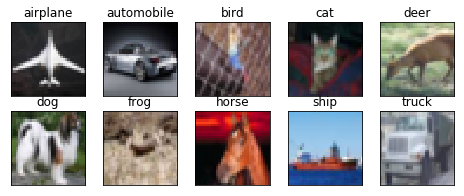

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
for_heatmap_plot = dict ()
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    for_heatmap_plot[ class_names[i] ] = train_features[idx]
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def get_all_layers (z, n, r):
  layers = []
  for i in range (n, n + r):
    layers.append (z + str (i))
  print (layers)
  return layers

In [0]:
def get_ratio (data, model, layer, x, index):
  
  def get_layer_output (img, model, layer):
    x = img.astype('float32')/255
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer (layer)
    
    grads = K.gradients (class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    p_num = 0
    p_sum = 0
    n_num = 0
    n_sum = 0
    for level1 in conv_layer_output_value:
      for level2 in level1:
        for level3 in level2:
          if level3 < 0:
            n_num += 1
            n_sum += level3
          else:
            p_num += 1
            p_sum += level3
    return (n_num / p_num, n_sum / p_sum)
  
  classes = list (data.keys ())
  if len (x.field_names) == 0:
    x.field_names = ['layer', 'index'] + ['average'] + classes
    
  T_sum = 0
  T_num = 0
  n = 0
  X = []
  
  for i, classe in enumerate (classes):
    (t_num, t_sum) = get_layer_output (data[ classes[i] ][:1], model, layer)
    X.append ([t_num, t_sum])
    T_num += t_num
    T_sum += t_sum
    n += 1
  x.add_row ([layer + ' : ratio_num', index] + [T_num / n] + [el[0] for el in X])
  x.add_row ([layer + ' : ratio_sum', index] + [T_sum / n] + [el[1] for el in X])
  if index != 10:
    x.add_row (['-----' for i in range (13)])
  return x

In [0]:
def get_layer_wise_ratio (layers, model):
  final_ratio = dict ()
  x = PrettyTable()
  x.field_names = []
  for i, layer in enumerate (layers):
    x = get_ratio (for_heatmap_plot, model, layer, x, i + 1)
  print (x)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def model_result (model):
  datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

  # train the model
  start = time.time()
  # Train the model
  filepath='weights-{val_acc:.6f}.hdf5'
  checkpoint = keras.callbacks.ModelCheckpoint (filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks = callbacks_list)
  end = time.time()
  print ("Model took %0.2f seconds to train"%(end - start))
  # plot model history
  plot_model_history(model_info)
  # compute test accuracy
  print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
  return model

In [0]:
# Define the model
def create_model (flag, index):
  model = Sequential()

  model.add(Convolution2D(48, 3, 3, input_shape=(32, 32, 3))) #32
  if flag == 1 and 1 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(48, 3, 3)) #30
  if flag == 1 and 2 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(96, 3, 3))
  if flag == 1 and 3 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(96, 3, 3))
  if flag == 1 and 4 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(96, 3, 3))
  if flag == 1 and 5 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(96, 3, 3))
  if flag == 1 and 6 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(192, 3, 3))
  if flag == 1 and 7 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(192, 3, 3))
  if flag == 1 and 8 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(192, 3, 3))
  if flag == 1 and 9 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Convolution2D(10, 1, 1))
  if flag == 1 and 10 not in index:
    model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Activation('softmax'))
  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model
models = dict ()
table = PrettyTable ()
table.field_names = ['model_name', 'best observed validation accuracy', 'time taken for 50 epochs']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 48)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 48)        20784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 48)        192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 96)        41568     
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 96)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  


Epoch 1/50
390/390 [==============================] - 29s 73ms/step - loss: 1.5297 - acc: 0.4947 - val_loss: 1.8511 - val_acc: 0.4062

Epoch 00001: val_acc improved from -inf to 0.40620, saving model to weights-0.406200.hdf5
Epoch 2/50
390/390 [==============================] - 23s 59ms/step - loss: 1.2880 - acc: 0.5841 - val_loss: 1.3592 - val_acc: 0.5377

Epoch 00002: val_acc improved from 0.40620 to 0.53770, saving model to weights-0.537700.hdf5
Epoch 3/50
390/390 [==============================] - 23s 60ms/step - loss: 1.1723 - acc: 0.6188 - val_loss: 1.2487 - val_acc: 0.5852

Epoch 00003: val_acc improved from 0.53770 to 0.58520, saving model to weights-0.585200.hdf5
Epoch 4/50
390/390 [==============================] - 23s 60ms/step - loss: 1.0884 - acc: 0.6439 - val_loss: 1.1725 - val_acc: 0.6112

Epoch 00004: val_acc improved from 0.58520 to 0.61120, saving model to weights-0.611200.hdf5
Epoch 5/50
390/390 [==============================] - 23s 59ms/step - loss: 1.0190 - acc: 0

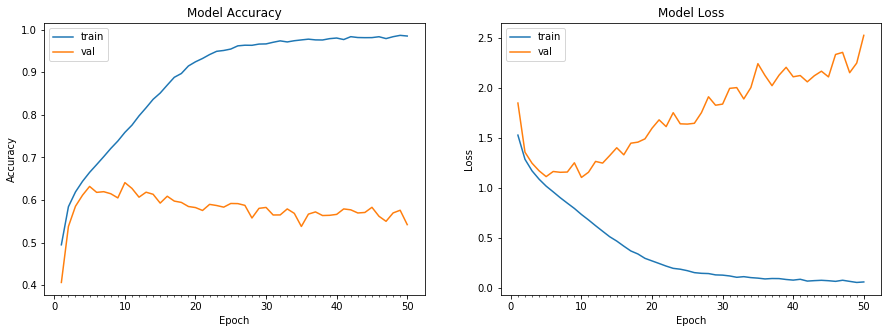

Accuracy on test data is: 54.20
['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_10']
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|         layer         | index |       average       |       airplane      |      automobile     |         bird        |         cat         |         deer        |         dog         |         frog        |        horse        |         ship        |        truck        |
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|  conv2d_1 : rati

In [12]:
models['without_any_activation'] = create_model (0, [0])
models['without_any_activation'].summary ()
models['without_any_activation'] = model_result (models['without_any_activation'])
layers = get_all_layers ('conv2d_', 1, 10)
get_layer_wise_ratio (layers, models['without_any_activation'])

In [0]:
table.add_row (['without_any_activation', '64', '1171.98'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-pac

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 48)        20784     
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 48)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 48)        192       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 96)       

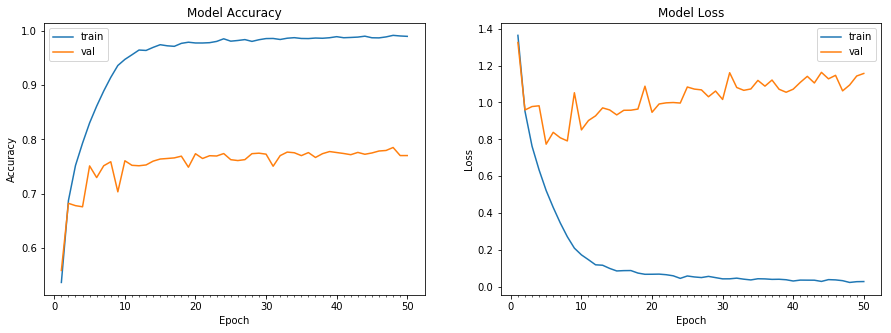

Accuracy on test data is: 77.03
['conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16', 'conv2d_17', 'conv2d_18', 'conv2d_19', 'conv2d_20']
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|         layer         | index |       average       |       airplane      |      automobile     |         bird        |         cat         |         deer        |         dog         |         frog        |        horse        |         ship        |        truck        |
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| conv2d_

In [14]:
models['with_relu_activation'] = create_model (1, [0])
models['with_relu_activation'].summary ()
models['with_relu_activation'] = model_result (models['with_relu_activation'])
layers = get_all_layers ('conv2d_', 11, 10)
get_layer_wise_ratio (layers, models['with_relu_activation'])

In [0]:
table.add_row (['with_relu_activation', '78.52', '1300.42'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-pac

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 48)        20784     
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 48)        192       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 96)        41568     
_________________________________________________________________
activation_14 (Activation)   (None, 26, 26, 96)       

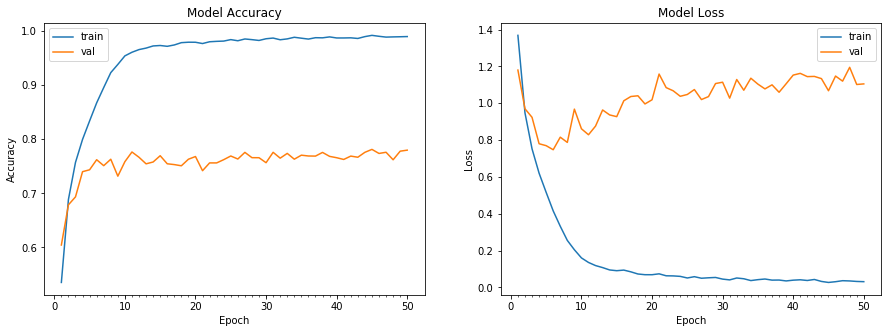

Accuracy on test data is: 77.98
['conv2d_21', 'conv2d_22', 'conv2d_23', 'conv2d_24', 'conv2d_25', 'conv2d_26', 'conv2d_27', 'conv2d_28', 'conv2d_29', 'conv2d_30']
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|         layer         | index |       average       |       airplane      |      automobile     |         bird        |         cat         |         deer        |         dog         |         frog        |        horse        |         ship        |        truck        |
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| conv2d_

In [17]:
models['with_relu_activation_2'] = create_model (1, [2])
models['with_relu_activation_2'].summary ()
models['with_relu_activation_2'] = model_result (models['with_relu_activation_2'])
layers = get_all_layers ('conv2d_', 21, 10)
get_layer_wise_ratio (layers, models['with_relu_activation_2'])

In [0]:
table.add_row (['with_relu_activation_2', '78.12', '1305.67'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-pac

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
activation_23 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 48)        20784     
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 48)        192       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 96)        41568     
_________________________________________________________________
batch_normalization_33 (Batc (None, 26, 26, 96)       

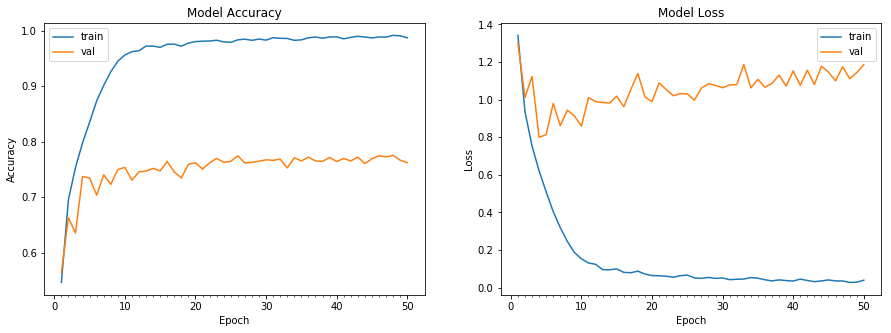

Accuracy on test data is: 76.23
['conv2d_31', 'conv2d_32', 'conv2d_33', 'conv2d_34', 'conv2d_35', 'conv2d_36', 'conv2d_37', 'conv2d_38', 'conv2d_39', 'conv2d_40']
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|         layer         | index |       average       |       airplane      |      automobile     |         bird        |         cat         |         deer        |         dog         |         frog        |        horse        |         ship        |        truck        |
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| conv2d_

In [19]:
models['with_relu_activation_2_3'] = create_model (1, [2, 3])
models['with_relu_activation_2_3'].summary ()
models['with_relu_activation_2_3'] = model_result (models['with_relu_activation_2_3'])
layers = get_all_layers ('conv2d_', 31, 10)
get_layer_wise_ratio (layers, models['with_relu_activation_2_3'])

In [0]:
table.add_row (['with_relu_activation_2_3', '77.55', '1303.76'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-pac

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
activation_32 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 48)        20784     
_________________________________________________________________
activation_33 (Activation)   (None, 28, 28, 48)        0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 28, 48)        192       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 26, 26, 96)       

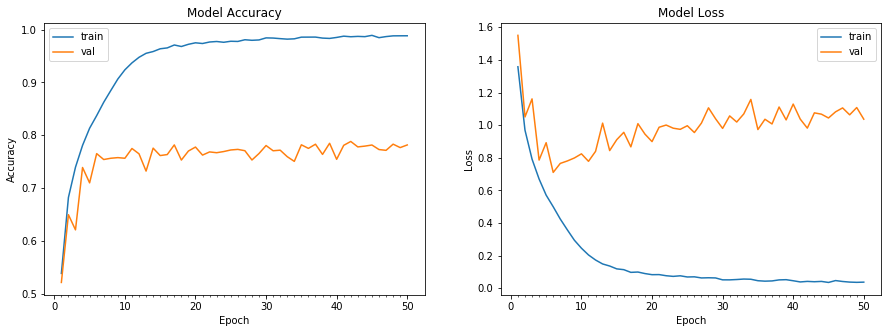

Accuracy on test data is: 78.14
['conv2d_41', 'conv2d_42', 'conv2d_43', 'conv2d_44', 'conv2d_45', 'conv2d_46', 'conv2d_47', 'conv2d_48', 'conv2d_49', 'conv2d_50']
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|         layer         | index |       average       |       airplane      |      automobile     |         bird        |         cat         |         deer        |         dog         |         frog        |        horse        |         ship        |        truck        |
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| conv2d_

In [20]:
models['with_relu_activation_7'] = create_model (1, [7])
models['with_relu_activation_7'].summary ()
models['with_relu_activation_7'] = model_result (models['with_relu_activation_7'])
layers = get_all_layers ('conv2d_', 41, 10)
get_layer_wise_ratio (layers, models['with_relu_activation_7'])

In [0]:
table.add_row (['with_relu_activation_7', '78.80', '1349.62'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-pac

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
activation_42 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 48)        20784     
_________________________________________________________________
activation_43 (Activation)   (None, 28, 28, 48)        0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 28, 28, 48)        192       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 26, 26, 96)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  


Epoch 1/50
390/390 [==============================] - 49s 126ms/step - loss: 1.3241 - acc: 0.5506 - val_loss: 1.5668 - val_acc: 0.4976

Epoch 00001: val_acc improved from -inf to 0.49760, saving model to weights-0.497600.hdf5
Epoch 2/50
390/390 [==============================] - 26s 66ms/step - loss: 0.9463 - acc: 0.6926 - val_loss: 1.0012 - val_acc: 0.6642

Epoch 00002: val_acc improved from 0.49760 to 0.66420, saving model to weights-0.664200.hdf5
Epoch 3/50
390/390 [==============================] - 26s 66ms/step - loss: 0.7690 - acc: 0.7500 - val_loss: 0.8430 - val_acc: 0.7206

Epoch 00003: val_acc improved from 0.66420 to 0.72060, saving model to weights-0.720600.hdf5
Epoch 4/50
390/390 [==============================] - 26s 65ms/step - loss: 0.6480 - acc: 0.7911 - val_loss: 0.7091 - val_acc: 0.7656

Epoch 00004: val_acc improved from 0.72060 to 0.76560, saving model to weights-0.765600.hdf5
Epoch 5/50
390/390 [==============================] - 26s 66ms/step - loss: 0.5508 - acc: 

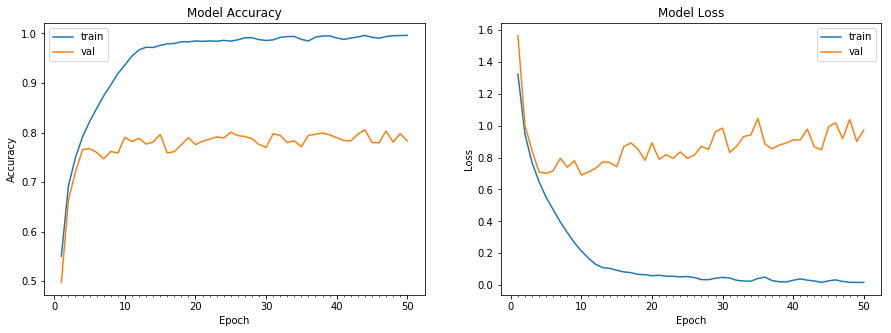

Accuracy on test data is: 78.30
['conv2d_51', 'conv2d_52', 'conv2d_53', 'conv2d_54', 'conv2d_55', 'conv2d_56', 'conv2d_57', 'conv2d_58', 'conv2d_59', 'conv2d_60']
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|         layer         | index |       average       |       airplane      |      automobile     |         bird        |         cat         |         deer        |         dog         |         frog        |        horse        |         ship        |        truck        |
+-----------------------+-------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| conv2d_

In [21]:
models['with_relu_activation_7_10'] = create_model (1, [7, 10])
models['with_relu_activation_7_10'].summary ()
models['with_relu_activation_7_10'] = model_result (models['with_relu_activation_7_10'])
layers = get_all_layers ('conv2d_', 51, 10)
get_layer_wise_ratio (layers, models['with_relu_activation_7_10'])

In [0]:
table.add_row (['with_relu_activation_7_10', '80.56', '1368.53'])

In [25]:
print (table)

+---------------------------+-----------------------------------+--------------------------+
|         model_name        | best observed validation accuracy | time taken for 50 epochs |
+---------------------------+-----------------------------------+--------------------------+
|   without_any_activation  |                 64                |         1171.98          |
|    with_relu_activation   |               78.52               |         1300.42          |
|   with_relu_activation_2  |               78.12               |         1305.67          |
|  with_relu_activation_2_3 |               77.55               |         1303.76          |
|   with_relu_activation_7  |               78.80               |         1349.62          |
| with_relu_activation_7_10 |               80.56               |         1368.53          |
+---------------------------+-----------------------------------+--------------------------+
